# Preamble

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision
import cv2
import matplotlib.pyplot as plt
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from google.colab import drive

from google.colab import files
import os
import copy
import pickle

import random

import torch.nn as nn
import torch.nn.functional as F
from random import shuffle
import torch.optim as optim

plt.rcParams["mathtext.default"]= 'regular'
plt_fontsize_text_ = 9
plt_fontsize_title_ = 9
plt_fontsize_label_ = 6
plt_fontsize_legend_ = 5


color_cycle =  [u'#1f77b4'    , u'#ff7f0e'    , u'#2ca02c'   , u'#d62728'   , u'#7f7f7f'   , u'#17becf'     , u'#9467bd'    ,  u'#8c564b'    , u'#e377c2'  ,   u'#7f7f7f' ]
color_cycle2 = [u'#1f77b455'  , u'#ff7f0e55'  , u'#2ca02c55' , u'#d6272855' , u'#7f7f7f55' , u'#17becf55'   , u'#9467bd55'  ,  u'#8c564b55'  , u'#e377c255'  ,   u'#7f7f7f55' ]

cm_to_inch = 1/2.54  # centimeters in inches
figure_width1 = 9*cm_to_inch
figure_width2 = 19*cm_to_inch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mount_drive = False
# base_directory_str = '/content/gdrive/My Drive/bio_NN_research/neural_balance'
base_directory_str = None

if mount_drive and (base_directory_str!= None):
    drive.mount('/content/gdrive', force_remount=True)



    base_directory_str = '/content/gdrive/My Drive/bio_NN_research/neural_balance'


    base_directory_data_str =  base_directory_str + '/data/neural_balance_v1/LC_CFAR10/'
    base_directory_figure_str =  base_directory_str + '/figures/neural_balance_v1/LC_CFAR10/'



    if not os.path.exists(  base_directory_data_str  ):
        os.makedirs( base_directory_data_str )
        print("data saving path did not exist and created")


    if not os.path.exists(  base_directory_figure_str  ):
        os.makedirs( base_directory_figure_str )
        print("figure saving path did not exist and created")


import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)



def export_legend(legend, filename  , expand=[-3,-3,3,3]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)




Mounted at /content/gdrive


# Defining LocallyConnected2d

In [ ]:
from torch.nn.modules.utils import _pair

class LocallyConnected2d(nn.Module):
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride, bias=False):
        super(LocallyConnected2d, self).__init__()
        output_size = _pair(output_size)

        self.output_size0 = output_size
        self.kernel_size0 = kernel_size
        self.stride0 = stride


        self.weight = nn.Parameter(
            torch.randn(1, out_channels, in_channels, output_size[0], output_size[1], kernel_size**2)*0.5
        )
        if bias:
            self.bias = nn.Parameter(
                torch.randn(1, out_channels, output_size[0], output_size[1])
            )
        else:
            self.register_parameter('bias', None)
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)

    def forward(self, x):
        #  c, h, w = x.size()
        kh, kw = self.kernel_size
        dh, dw = self.stride
        x = x.unfold(2, kh, dh).unfold(3, kw, dw)
        x = x.contiguous().view(*x.size()[:-2], -1)
        # Sum in in_channel and kernel_size dims
        out = (x.unsqueeze(1) * self.weight).sum([2, -1])
        if self.bias is not None:
            out += self.bias
        return out




# Preparing the dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




100%|██████████| 170498071/170498071 [00:06<00:00, 27195830.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# input_weights_norm_conv


In [ ]:
def input_weights_norm_conv(output_shape , conv):
    conv_copy = copy.deepcopy(conv)


    conv_copy.weight.data.copy_ ( conv_copy.weight**2)

    input_weights_channels_norms = conv_copy.weight.data.sum(dim=1).sum(dim=1).sum(dim=1)

    out = torch.zeros(output_shape)

    for i in range(input_weights_channels_norms.shape[0]):

        out[i,:,:] = input_weights_channels_norms[i]

    return out



# output_weights_norm_conv

In [ ]:
def output_weights_norm_conv(input_shape , conv):
    conv_copy = copy.deepcopy(conv)


    conv_copy.weight.data.copy_ ( conv_copy.weight**2)




    x = torch.zeros(input_shape)
    out = torch.zeros(input_shape)


    for i in range(input_shape[0]):
        for j in range(input_shape[1]):
            for k in range(input_shape[2]):

                x[i,j,k] = 1

                out[i,j,k] =  conv_copy(x).sum()
                x[i,j,k] = 0



    return out







# neural_map_locally_conn_conv

In [ ]:
def neural_map_locally_conn_conv(input_shape , conv):
  with torch.no_grad() :

      input_shape1 = input_shape[1]
      input_shape = [1, 1 , input_shape[2] , input_shape[3]]


      conv_copy = LocallyConnected2d(1,1,conv.output_size0 , conv.kernel_size0 , conv.stride0).to(device)

      neural_map_input = torch.zeros_like(conv.weight.data)
      neural_map_output = torch.zeros_like(conv.weight.data)

      conv_copy.weight.data[:] = 0

      w_shape = conv.weight.data.shape




      for i4 in range(w_shape[3]):
        for i5 in range(w_shape[4]):

            for i2 in range(w_shape[1]):

                  id = (i2+1)*1000000 + (i4+1) *1000  + (i5+1)
                  neural_map_input [0,i2,:,i4,i5,:] =  id


      ###############
      x = torch.zeros(input_shape).to(device)


      for i in range(input_shape[1]):
        for j in range(input_shape[2]):
            for k in range(input_shape[3]):

                x[0,i,j,k] =  (j+1) *1000  + (k+1)



      i2 = 0
      i3 = 0

      for i4 in range(w_shape[3]):
        for i5 in range(w_shape[4]):
          for i6 in range(w_shape[5]):

            conv_copy.weight.data[0,0,0,i4,i5,i6] = 1

            y = conv_copy(x.to(device))
            id = y.sum()
            conv_copy.weight.data[0,0,0,i4,i5,i6] = 0


            for i3 in range(w_shape[2]):
              neural_map_output [0,:,i3,i4,i5,i6] = (i3+1)*1000000 + id




      locs_output = []

      for i in range(input_shape1):
          locs_output_j = []
          for j in range(input_shape[2]):
              locs_output_k = []
              for k in range(input_shape[3]):
                loc = torch.where(neural_map_output  == (i+1)*1000000 + (j+1) *1000  + (k+1) )

                locs_output_k.append(loc)

              locs_output_j . append(locs_output_k)

          locs_output . append(locs_output_j)





      return neural_map_input , neural_map_output , locs_output





# input_weights_norm_locally_conn_conv

In [ ]:
def input_weights_norm_locally_conn_conv(input_shape , conv):

    input_shape = [1, input_shape[1] , input_shape[2] , input_shape[3]]

    conv_copy = copy.deepcopy(conv)

    conv_copy.weight.data.copy_ ( conv_copy.weight**2)

    x = torch.ones(input_shape).to(device)


    return conv_copy(x)






# output_weights_norm_locally_conn_conv

In [ ]:
def output_weights_norm_locally_conn_conv(input_shape , conv  , locs_output ):
  with torch.no_grad() :
    conv_copy = copy.deepcopy(conv)

    input_shape = [1, input_shape[1] , input_shape[2] , input_shape[3]]


    conv_copy.weight.data.copy_ ( conv_copy.weight**2)



    weights_ = conv_copy.weight.data.clone()


    x = torch.zeros(input_shape).to(device)
    out = torch.zeros(input_shape).to(device)





    for i in range(input_shape[1]):
      for j in range(input_shape[2]):
        for k in range(input_shape[3]):



          loc  =  locs_output[i][j][k]


          out[0,i,j,k]  =  weights_ [loc] .sum()




    return out




# balance_input_weights_norm_locally_conn_conv

In [ ]:
def balance_input_weights_norm_locally_conn_conv( input_shape , multiply , conv):
  with torch.no_grad() :
    input_shape = [1, input_shape[1] , input_shape[2] , input_shape[3]]

    conv_copy = copy.deepcopy(conv)


    weights_ = conv_copy.weight.data.clone()



    x = torch.ones(input_shape).to(device)

    y = conv_copy(x)




    for i in (range(y.shape[1])  ):
      for j in (range(y.shape[2])  ):
        for k in  (range(y.shape[3])  ):


          weights_ [:,i,:,j,k,:] *= multiply[  0 , i , j , k ].item()



    return weights_




# balance_output_weights_norm_locally_conn_conv

In [ ]:
def balance_output_weights_norm_locally_conn_conv(input_shape , multiply , conv  , locs_output   ):
  with torch.no_grad() :

    conv_copy = copy.deepcopy(conv)

    input_shape = [1, input_shape[1] , input_shape[2] , input_shape[3]]

    weights_ = conv_copy.weight.data.clone()
    nn = 0

    for i in (range(input_shape[1])  ):
        for j in (range(input_shape[2])  ):
            for k in (range(input_shape[3]) ):

              loc  =  locs_output[i][j][k]

              weights_ [loc] *= multiply[  0 , i , j , k ].item()




    return weights_






# balance_neurons_in_the_middle_of_two_locally_connected_layers

In [ ]:
def balance_neurons_in_the_middle_of_two_locally_connected_layers( conv1 , conv2 , layer_shape , ratio   , locs_output  , n   ):


  with torch.no_grad() :


    nn=0
    for i in random.sample(range(layer_shape[1]) , (layer_shape[1]) ):
      for j in  random.sample(range(layer_shape[2]) , (layer_shape[2]) ):
        for k in  random.sample(range(layer_shape[3]) , (layer_shape[3]) ):

          conv1.weight.data [:,i,:,j,k,:] *= ratio[  0 , i , j , k ].item()

          loc  =  locs_output[i][j][k]

          conv2.weight.data [loc] /= ratio[  0 , i , j , k ].item()



          nn +=1
          if nn > n:
            break





# balance_neurons_in_the_middle_of_a_locally_connected_layers_and_a_fc_layer

In [ ]:
def balance_neurons_in_the_middle_of_a_locally_connected_layers_and_a_fc_layer( conv1 , fc , layer_shape , ratio     , n   ):

  with torch.no_grad() :


    nn=0
    for i in random.sample(range(layer_shape[1]) , (layer_shape[1]) ):
      for j in  random.sample(range(layer_shape[2]) , (layer_shape[2]) ):
        for k in  random.sample(range(layer_shape[3]) , (layer_shape[3]) ):



          m =  k + layer_shape[3]* j + layer_shape[3]*layer_shape[2]* i



          conv1.weight.data [:,i,:,j,k,:] *= ratio[  m ].item()

          fc.weight.data [:,m] /= ratio[  m ].item()






          nn +=1
          if nn > n:
            break





# balance_neurons_in_the_middle_of_fc_layers

In [ ]:
def balance_neurons_in_the_middle_of_fc_layers( fc1 , fc2  , ratio     , n   ):

  with torch.no_grad() :


    nn=0
    for i in random.sample(range(ratio.shape[0]) , (ratio.shape[0]) ):






          fc1.weight.data [i,:] *= ratio[  i ].item()

          fc2.weight.data [:,i] /= ratio[  i ].item()





          nn +=1
          if nn > n:
            break





# network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F




class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.set_shapes_flag = False

        self.LeakyReLU = nn.LeakyReLU(0.1)

        self.conv1 = LocallyConnected2d(
                in_channels=3, out_channels=8, output_size = 25 , kernel_size=8, stride=1, bias=False)



        self.conv2 = LocallyConnected2d(
                in_channels=8, out_channels=8, output_size = 18 , kernel_size=8, stride=1, bias=False)

        self.conv3 = LocallyConnected2d(
                in_channels=8 , out_channels=16, output_size = 9 , kernel_size=10, stride=1, bias=False)







        self.fc1 = nn.Linear(1296  , 300 , bias=False)
        self.fc2 = nn.Linear(300, 100 , bias=False)
        self.fc3 = nn.Linear(100, 10 , bias=False)

        initial_std = 0.1
        self.conv1.weight.data.copy_( torch.randn_like( self.conv1.weight.data) *initial_std  )
        self.conv2.weight.data.copy_(torch.randn_like( self.conv2.weight.data) *initial_std )
        self.conv3.weight.data.copy_(torch.randn_like( self.conv3.weight.data) *initial_std )
        self.fc1.weight.data.copy_(torch.randn_like( self.fc1.weight.data) *initial_std )
        self.fc2.weight.data.copy_(torch.randn_like( self.fc2.weight.data)  *initial_std)
        self.fc3.weight.data.copy_(torch.randn_like( self.fc3.weight.data)  *initial_std )



    def forward(self, x):
        self.x0 = x
        self.x1 = (self.LeakyReLU(self.conv1(self.x0)))
        self.x2 = (self.LeakyReLU(self.conv2(self.x1)))
        self.x3 = (self.LeakyReLU(self.conv3(self.x2)))

        self.x4 = torch.flatten(self.x3, 1) # flatten all dimensions except batch
        # print(x.shape)
        self.x5 = self.LeakyReLU(self.fc1(self.x4))
        self.x6 = self.LeakyReLU(self.fc2(self.x5))
        self.x7 = self.fc3(self.x6)
        return self.x7

    def save_weights(self ):
        self.save_weights_conv1 = self.conv1.weight.data.clone()
        self.save_weights_conv2 = self.conv2.weight.data.clone()
        self.save_weights_conv3 = self.conv3.weight.data.clone()
        self.save_weights_fc1 = self.fc1.weight.data.clone()
        self.save_weights_fc2 =self.fc2.weight.data.clone()
        self.save_weights_fc3 = self.fc3.weight.data.clone()

    def load_weights(self ):
        self.conv1.weight.data.copy_(self.save_weights_conv1  )
        self.conv2.weight.data.copy_(self.save_weights_conv2 )
        self.conv3.weight.data.copy_(self.save_weights_conv3 )
        self.fc1.weight.data.copy_(self.save_weights_fc1 )
        self.fc2.weight.data.copy_(self.save_weights_fc2 )
        self.fc3.weight.data.copy_(self.save_weights_fc3 )

    def reinitialize_weights(self , initial_std = 0.1):

        self.conv1.weight.data.copy_( torch.randn_like( self.conv1.weight.data) *initial_std  )
        self.conv2.weight.data.copy_(torch.randn_like( self.conv2.weight.data) *initial_std )
        self.conv3.weight.data.copy_(torch.randn_like( self.conv3.weight.data) *initial_std )
        self.fc1.weight.data.copy_(torch.randn_like( self.fc1.weight.data) *initial_std )
        self.fc2.weight.data.copy_(torch.randn_like( self.fc2.weight.data)  *initial_std)
        self.fc3.weight.data.copy_(torch.randn_like( self.fc3.weight.data)  *initial_std )


    def neuron_wise_imbalancement(self):
        # print("neuron_wise_imbalancement start")
        with torch.no_grad() :
            output_shape = self.x0.shape
            input_shape = self.x1.shape

            sum = 0

            norm_in = input_weights_norm_locally_conn_conv(output_shape , self.conv1 )
            norm_out = output_weights_norm_locally_conn_conv(input_shape , self.conv2 , self.conv2_locs_output)

            sum = ((norm_in - norm_out)**2).sum()


            output_shape = self.x1.shape
            input_shape = self.x2.shape

            norm_in = input_weights_norm_locally_conn_conv(output_shape , self.conv2 )
            norm_out = output_weights_norm_locally_conn_conv(input_shape , self.conv3 , self.conv3_locs_output )

            sum += ((norm_in - norm_out)**2).sum()

            output_shape = self.x2.shape

            norm_in = input_weights_norm_locally_conn_conv(output_shape , self.conv3 )
            norm_in= norm_in.flatten()

            norm_out =  (self.fc1.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()




            norm_in = (self.fc1.weight.data**2).sum(dim=1)

            norm_out =  (self.fc2.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()



            norm_in = (self.fc2.weight.data**2).sum(dim=1)

            norm_out =  (self.fc3.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()


            return sum



    def norm_of_weights(self):
        norm = 0

        norm+=self.conv1.weight.data .norm()**2
        norm+=self.conv2.weight.data .norm()**2
        norm+=self.conv3.weight.data .norm()**2

        norm+=self.fc1.weight.data.norm()**2
        norm+=self.fc2.weight.data.norm()**2
        norm+=self.fc3.weight.data.norm()**2

        return norm



    def weight_decay(self,wd):
        with torch.no_grad() :

          self.conv1.weight.data -= self.conv1.weight.data * wd
          self.conv2.weight.data -= self.conv2.weight.data * wd
          self.conv3.weight.data -= self.conv3.weight.data * wd

          self.fc1.weight.data -= self.fc1.weight.data * wd
          self.fc2.weight.data -= self.fc2.weight.data * wd
          self.fc3.weight.data -= self.fc3.weight.data * wd

    def regularization_L1(self,wd):
        with torch.no_grad() :


          self.conv1.weight.data -= torch.sign(self.conv1.weight.data) * wd
          self.conv2.weight.data -= torch.sign(self.conv2.weight.data) * wd
          self.conv3.weight.data -= torch.sign(self.conv3.weight.data) * wd

          self.fc1.weight.data -= torch.sign(self.fc1.weight.data) * wd
          self.fc2.weight.data -= torch.sign(self.fc2.weight.data) * wd
          self.fc3.weight.data -= torch.sign(self.fc3.weight.data) * wd




    def stochastic_balance(self):
        # print("stochastic_balance start")
        with torch.no_grad() :
            iii = random.randint(0, 4)
            # iii = 3


            if iii == 0:

              output_shape = self.x0.shape
              input_shape = self.x1.shape

              norm_in = input_weights_norm_locally_conn_conv(output_shape , self.conv1)
              norm_out = output_weights_norm_locally_conn_conv(input_shape , self.conv2  , self.conv2_locs_output )

              ratio = (norm_out/norm_in ).sqrt().sqrt()

              # weights_ = balance_output_weights_norm_locally_conn_conv( self.x1_shape  , 1/ratio , self.conv2   , self.conv2_locs_output)
              # self.conv2.weight.data.copy_(weights_)
              # weights_ = balance_input_weights_norm_locally_conn_conv( self.x0_shape  , ratio , self.conv1    )
              # self.conv1.weight.data.copy_(weights_)

              balance_neurons_in_the_middle_of_two_locally_connected_layers( self.conv1 , self.conv2
                                                                            , layer_shape = self.x1.shape , ratio = ratio
                                                                            , locs_output = self.conv2_locs_output   , n = 99999999999   )


            if iii == 1:


              output_shape = self.x1.shape
              input_shape = self.x2.shape



              norm_in = input_weights_norm_locally_conn_conv(output_shape , self.conv2 )
              norm_out = output_weights_norm_locally_conn_conv(input_shape , self.conv3  , self.conv3_locs_output  )

              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_two_locally_connected_layers( self.conv2 , self.conv3
                                                                            , layer_shape = self.x2.shape , ratio = ratio
                                                                            , locs_output = self.conv3_locs_output   , n = 999999999999999999   )

            if iii == 2:

              output_shape = self.x2.shape
              norm_in_initial = input_weights_norm_locally_conn_conv(output_shape , self.conv3 )
              norm_in_shape0 = norm_in_initial.shape

              if ( (norm_in_initial.flatten().view(norm_in_shape0)  - norm_in_initial).abs().norm() != 0 ):
                raise Exception("Dimention view mismatch" + str((norm_in.flatten().view(norm_in_shape0)  - norm_in).abs().norm()))

              norm_in = norm_in_initial.flatten()
              norm_out =  (self.fc1.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_a_locally_connected_layers_and_a_fc_layer( self.conv3 , self.fc1
                                                                                         , layer_shape = norm_in_shape0
                                                                                         , ratio = ratio     , n = 999999999999999   )


            if iii == 3:

              norm_in = (self.fc1.weight.data**2).sum(dim=1)
              norm_out =  (self.fc2.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()


              balance_neurons_in_the_middle_of_fc_layers( self.fc1 , self.fc2  , ratio = ratio     , n = 999999999999   )

            if iii == 4:

              norm_in = (self.fc2.weight.data**2).sum(dim=1)
              norm_out =  (self.fc3.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()


              balance_neurons_in_the_middle_of_fc_layers( self.fc2 , self.fc3 , ratio = ratio     , n = 99999999999   )



    def set_shapes(self,input_shape):

      if self.set_shapes_flag == False:
        with torch.no_grad() :
          self.x0_shape = input_shape
          x = torch.ones(input_shape).to(device)


          output = self.forward(x)

          self.x1_shape = self.x1.shape
          self.x2_shape = self.x2.shape
          self.x3_shape = self.x3.shape
          self.x4_shape = self.x4.shape
          self.x5_shape = self.x5.shape
          self.x6_shape = self.x6.shape
          self.x7_shape = self.x7.shape

          self.conv1_neural_map_input , self.conv1_neural_map_output , self.conv1_locs_output =  neural_map_locally_conn_conv( self.x0_shape , self.conv1 )
          self.conv2_neural_map_input , self.conv2_neural_map_output , self.conv2_locs_output=  neural_map_locally_conn_conv( self.x1_shape , self.conv2 )
          self.conv3_neural_map_input , self.conv3_neural_map_output , self.conv3_locs_output=  neural_map_locally_conn_conv( self.x2_shape , self.conv3 )
          self.set_shapes_flag = True




net = Net()




# 1) illustrating that gd applied to E in general does not converge to a balanced state (unless starting state is balanced and learning rate is infinitely small)

## small lr , unbalanced

In [ ]:
net = Net()
net.to(device)
net.set_shapes([1,3,32,32])





In [ ]:


N_repeat = 10
N_epoch  = 3
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(trainloader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0

for epoch in range(N_epoch):
    print(f"\nrep_i: {rep_i}\n")

    iteration = 0

    net.reinitialize_weights(.04)





    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.007)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)



        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        norm_W[0,rep_i,iteration] =  net.norm_of_weights()

        if iteration % 1000 == 999 or  iteration==0:    # print every 2000 mini-batches
          neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



          neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()

        if iteration % 1000 == 999 or  iteration==0:    # print every 2000 mini-batches

          print(f"neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}")


        optimizer.step()



        loss_tensor[ rep_i,iteration] =  loss.item()


        running_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')

        if iteration % 100 == 99:
            loss_tensor[ rep_i,iteration] =  running_loss / 100

            running_loss = 0.0


        iteration +=1

print('Training Finished')

LC_BP_without_L2_regularization_small_lr = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32),
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}




if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_small_lr  , fp)


tensor(3136.4048, device='cuda:0')
tensor(3136.4031, device='cuda:0')
tensor(3136.3823, device='cuda:0')
[1,  2000] loss: 2.170
tensor(3136.2632, device='cuda:0')
tensor(3136.0981, device='cuda:0')
[1,  4000] loss: 1.931
tensor(3135.9626, device='cuda:0')
tensor(3135.8599, device='cuda:0')
[1,  6000] loss: 1.822
tensor(3135.8003, device='cuda:0')
tensor(3135.8079, device='cuda:0')
[1,  8000] loss: 1.715
tensor(3135.8708, device='cuda:0')
tensor(3135.9946, device='cuda:0')
[1, 10000] loss: 1.697
tensor(3138.2000, device='cuda:0')
tensor(3138.1990, device='cuda:0')
tensor(3138.1865, device='cuda:0')
[2,  2000] loss: 2.173
tensor(3138.0991, device='cuda:0')
tensor(3137.9658, device='cuda:0')
[2,  4000] loss: 1.939
tensor(3137.8643, device='cuda:0')
tensor(3137.8064, device='cuda:0')
[2,  6000] loss: 1.799
tensor(3137.7969, device='cuda:0')
tensor(3137.8445, device='cuda:0')
[2,  8000] loss: 1.646
tensor(3137.9609, device='cuda:0')
tensor(3138.1375, device='cuda:0')
[2, 10000] loss: 1.651


## big lr , unbalanced

In [ ]:



N_repeat = 10
N_epoch  = 1
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(trainloader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0

for rep_i in range(N_repeat):
  print(f"\nrep_i: {rep_i}\n")

  iteration = 0
  net.reinitialize_weights(.04)


  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.02)
  running_loss = 0.0

  for epoch in range(N_epoch):

      for i, data in enumerate(trainloader, 0):

          inputs, labels = data[0].to(device), data[1].to(device)



          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()

          norm_W[0,rep_i,iteration] =  net.norm_of_weights()
          if iteration % 1000 == 999 or  iteration==0:
            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()

          if iteration % 1000 == 999 or  iteration==0:

            print(f"neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}")


          optimizer.step()






          running_loss += loss.item()

          if i % 2000 == 1999:
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')

          if iteration % 100 == 99:
              loss_tensor[ rep_i,iteration] =  running_loss / 100

              running_loss = 0.0


          iteration +=1


print('Training Finished')

LC_BP_without_L2_regularization_big_lr = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32),
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}










if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_big_lr  , fp)



rep_i: 0

neuron_wise_imbalancement_t: 3147.95703125
neuron_wise_imbalancement_t: 3147.71826171875
neuron_wise_imbalancement_t: 3147.201416015625
[1,  2000] loss: 1.901
neuron_wise_imbalancement_t: 3147.129150390625
neuron_wise_imbalancement_t: 3147.48046875
[1,  4000] loss: 1.728
neuron_wise_imbalancement_t: 3148.13037109375
neuron_wise_imbalancement_t: 3149.38916015625
[1,  6000] loss: 1.648
neuron_wise_imbalancement_t: 3150.80322265625
neuron_wise_imbalancement_t: 3152.62451171875
[1,  8000] loss: 1.589
neuron_wise_imbalancement_t: 3154.7529296875
neuron_wise_imbalancement_t: 3157.3154296875
[1, 10000] loss: 1.462

rep_i: 1

neuron_wise_imbalancement_t: 3142.53515625
neuron_wise_imbalancement_t: 3142.3515625
neuron_wise_imbalancement_t: 3141.876220703125
[1,  2000] loss: 1.912
neuron_wise_imbalancement_t: 3141.70947265625
neuron_wise_imbalancement_t: 3142.15380859375
[1,  4000] loss: 1.699
neuron_wise_imbalancement_t: 3143.22705078125
neuron_wise_imbalancement_t: 3144.7939453125
[1

## big lr , unbalanced with L2 regularizer

In [ ]:



N_repeat = 10
N_epoch  = 1
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(trainloader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0
for rep_i in range(N_repeat):
  print(f"\nrep_i: {rep_i}\n")

  iteration = 0

  net.reinitialize_weights(.04)





  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.05)

  running_loss = 0.0

  for epoch in range(N_epoch):

      for i, data in enumerate(trainloader, 0):

          inputs, labels = data[0].to(device), data[1].to(device)



          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()

          norm_W[0,rep_i,iteration] =  net.norm_of_weights()
          if iteration % 1000 == 999 or  iteration==0:
            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()

          if iteration % 1000 == 999 or  iteration==0:

            print(f"neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}")


          optimizer.step()





          net.weight_decay(0.0002)

          running_loss += loss.item()

          if i % 2000 == 1999:
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')

          if iteration % 100 == 99:
              loss_tensor[ rep_i,iteration] =  running_loss / 100

              running_loss = 0.0

          iteration +=1

print('Training Finished')

LC_BP_with_L2_regularization_big_lr = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32),
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}




if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_with_L2_regularization_big_lr  , fp)


rep_i: 0

neuron_wise_imbalancement_t: 3145.56396484375
neuron_wise_imbalancement_t: 1413.3018798828125
neuron_wise_imbalancement_t: 633.9754028320312
[1,  2000] loss: 1.938
neuron_wise_imbalancement_t: 284.44000244140625
neuron_wise_imbalancement_t: 127.68914031982422
[1,  4000] loss: 1.778
neuron_wise_imbalancement_t: 57.45112609863281
neuron_wise_imbalancement_t: 25.95003318786621
[1,  6000] loss: 1.715
neuron_wise_imbalancement_t: 11.941617965698242
neuron_wise_imbalancement_t: 5.683918476104736
[1,  8000] loss: 1.702
neuron_wise_imbalancement_t: 2.911595582962036
neuron_wise_imbalancement_t: 1.7078379392623901
[1, 10000] loss: 1.603

rep_i: 1

neuron_wise_imbalancement_t: 3138.17431640625
neuron_wise_imbalancement_t: 1410.083984375
neuron_wise_imbalancement_t: 632.6263427734375
[1,  2000] loss: 1.874
neuron_wise_imbalancement_t: 283.9599304199219
neuron_wise_imbalancement_t: 127.51606750488281
[1,  4000] loss: 1.760
neuron_wise_imbalancement_t: 57.363494873046875
neuron_wise_imba

## small lr initially balanced

In [ ]:
N_repeat = 2


N_iter  = 300




N_epoch  = 1
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(trainloader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0


for rep_i in range(N_repeat):
  print(f"\nrep_i: {rep_i}\n")

  iteration = 0

  net.reinitialize_weights(.1)

  for i in range(N_iter):
    iteration = 0

    norm_W0 = net. norm_of_weights()
    neuron_wise_imbalancement0 = net.neuron_wise_imbalancement()
    if i%20 ==  0:
      print(neuron_wise_imbalancement0 , norm_W0)

    net.stochastic_balance()



  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.005)


  for epoch in range(N_epoch):

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

          inputs, labels = data[0].to(device), data[1].to(device)



          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()

          norm_W[0,rep_i,iteration] =  net.norm_of_weights()
          if iteration % 100 == 99 or  iteration==0:
            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()

          if iteration % 1000 == 999 or  iteration==0:

            print(f"neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}")


          optimizer.step()





          running_loss += loss.item()

          if i % 2000 == 1999:
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')


          if iteration % 100 == 99:
              loss_tensor[ rep_i,iteration] =  running_loss / 100

              running_loss = 0.0




          iteration +=1


print('Training Finished')

LC_BP_without_L2_regularization_small_lr_initial_balance = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32),
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}


if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_small_lr_initial_balance  , fp)


rep_i: 0

tensor(123090.7812, device='cuda:0') tensor(37461.5547, device='cuda:0')
tensor(18415.5918, device='cuda:0') tensor(15023.1738, device='cuda:0')
tensor(2023.0122, device='cuda:0') tensor(9964.2881, device='cuda:0')
tensor(1277.6729, device='cuda:0') tensor(9198.1836, device='cuda:0')
tensor(2336.9917, device='cuda:0') tensor(8925.4863, device='cuda:0')
tensor(481.2581, device='cuda:0') tensor(8808.1416, device='cuda:0')
tensor(21.1007, device='cuda:0') tensor(8731.6934, device='cuda:0')
tensor(7.4681, device='cuda:0') tensor(8720.5693, device='cuda:0')
tensor(9.7599, device='cuda:0') tensor(8712.6074, device='cuda:0')
tensor(3.2700, device='cuda:0') tensor(8711.3096, device='cuda:0')
tensor(3.4497, device='cuda:0') tensor(8710.9268, device='cuda:0')
tensor(0.5626, device='cuda:0') tensor(8710.4658, device='cuda:0')
tensor(0.2432, device='cuda:0') tensor(8710.4004, device='cuda:0')
tensor(0.0513, device='cuda:0') tensor(8710.3779, device='cuda:0')
tensor(0.0280, device='cuda:

## big lr initially balanced

In [ ]:


N_repeat = 2
N_epoch  = 1
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(trainloader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0

for rep_i in range(N_repeat):
  print(f"\nrep_i: {rep_i}\n")

  iteration = 0
  net.reinitialize_weights(.1)

  for i in range(N_iter):
    iteration = 0

    norm_W0 = net. norm_of_weights()
    neuron_wise_imbalancement0 = net.neuron_wise_imbalancement()
    if i%20 ==  0:
      print(neuron_wise_imbalancement0 , norm_W0)

    net.stochastic_balance()


  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.033)

  for epoch in range(N_epoch):

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

          inputs, labels = data[0].to(device), data[1].to(device)



          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()

          norm_W[0,rep_i,iteration] =  net.norm_of_weights()
          if iteration % 100 == 99 or  iteration==0:
            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()

          if iteration % 1000 == 999 or  iteration==0:

            print(f"neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}")


          optimizer.step()






          running_loss += loss.item()
          if i % 2000 == 1999:
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')



          if iteration % 100 == 99:
              loss_tensor[ rep_i,iteration] =  running_loss / 100

              running_loss = 0.0
          iteration +=1

print('Training Finished')

LC_BP_without_L2_regularization_big_lr_initial_balance = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32),
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}



if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_big_lr_initial_balance  , fp)


rep_i: 0

tensor(122458.6953, device='cuda:0') tensor(37406.7188, device='cuda:0')
tensor(63483.0156, device='cuda:0') tensor(27946.2285, device='cuda:0')
tensor(7607.9429, device='cuda:0') tensor(14162.7500, device='cuda:0')
tensor(3644.2102, device='cuda:0') tensor(10207.1309, device='cuda:0')
tensor(1367.6047, device='cuda:0') tensor(9130.3252, device='cuda:0')
tensor(335.1827, device='cuda:0') tensor(8731.2314, device='cuda:0')
tensor(52.5371, device='cuda:0') tensor(8646.0703, device='cuda:0')
tensor(8.7701, device='cuda:0') tensor(8624.6230, device='cuda:0')
tensor(9.8909, device='cuda:0') tensor(8615.4697, device='cuda:0')
tensor(19.4787, device='cuda:0') tensor(8613.6895, device='cuda:0')
tensor(3.4509, device='cuda:0') tensor(8612.9131, device='cuda:0')
tensor(0.0545, device='cuda:0') tensor(8612.6719, device='cuda:0')
tensor(0.0952, device='cuda:0') tensor(8612.6211, device='cuda:0')
tensor(0.0117, device='cuda:0') tensor(8612.6084, device='cuda:0')
tensor(0.0059, device='cu

## big lr initially balanced with regularizer

In [ ]:


N_repeat = 2
N_epoch  = 1
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(trainloader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(trainloader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0

for rep_i in range(N_repeat):
  print(f"\nrep_i: {rep_i}\n")

  iteration = 0
  net.reinitialize_weights(.1)

  for i in range(N_iter):
    iteration = 0

    norm_W0 = net. norm_of_weights()
    neuron_wise_imbalancement0 = net.neuron_wise_imbalancement()
    if i%20 ==  0:
      print(neuron_wise_imbalancement0 , norm_W0)

    net.stochastic_balance()


  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.033)

  for epoch in range(N_epoch):

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

          inputs, labels = data[0].to(device), data[1].to(device)



          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()

          norm_W[0,rep_i,iteration] =  net.norm_of_weights()
          if iteration % 100 == 99 or  iteration==0:
            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()

          if iteration % 1000 == 999 or  iteration==0:

            print(f"neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}")


          optimizer.step()






          net.weight_decay(0.0002)


          running_loss += loss.item()
          if i % 2000 == 1999:
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')

          if iteration % 100 == 99:
              loss_tensor[ rep_i,iteration] =  running_loss / 100

              running_loss = 0.0
          iteration +=1

print('Training Finished')

LC_BP_with_L2_regularization_big_lr_initial_balance = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32),
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}



if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_with_L2_regularization_big_lr_initial_balance  , fp)


rep_i: 0

tensor(122933.4141, device='cuda:0') tensor(37422.6094, device='cuda:0')
tensor(26764.9570, device='cuda:0') tensor(18370.2949, device='cuda:0')
tensor(3160.4307, device='cuda:0') tensor(11214.7549, device='cuda:0')
tensor(1305.1188, device='cuda:0') tensor(9561.4004, device='cuda:0')
tensor(899.7305, device='cuda:0') tensor(9243.2666, device='cuda:0')
tensor(352.7844, device='cuda:0') tensor(8837.6797, device='cuda:0')
tensor(189.2231, device='cuda:0') tensor(8789.4062, device='cuda:0')
tensor(84.3826, device='cuda:0') tensor(8634.9219, device='cuda:0')
tensor(11.1303, device='cuda:0') tensor(8605.8623, device='cuda:0')
tensor(17.3116, device='cuda:0') tensor(8600.6025, device='cuda:0')
tensor(1.5279, device='cuda:0') tensor(8596.7295, device='cuda:0')
tensor(0.6535, device='cuda:0') tensor(8596.0078, device='cuda:0')
tensor(0.8708, device='cuda:0') tensor(8595.7910, device='cuda:0')
tensor(0.3617, device='cuda:0') tensor(8595.7090, device='cuda:0')
tensor(0.6152, device='c

## plot Neuron-wise imbalancement with regularazer vs without regularizer

torch.Size([10, 10000])
torch.Size([10, 10000])


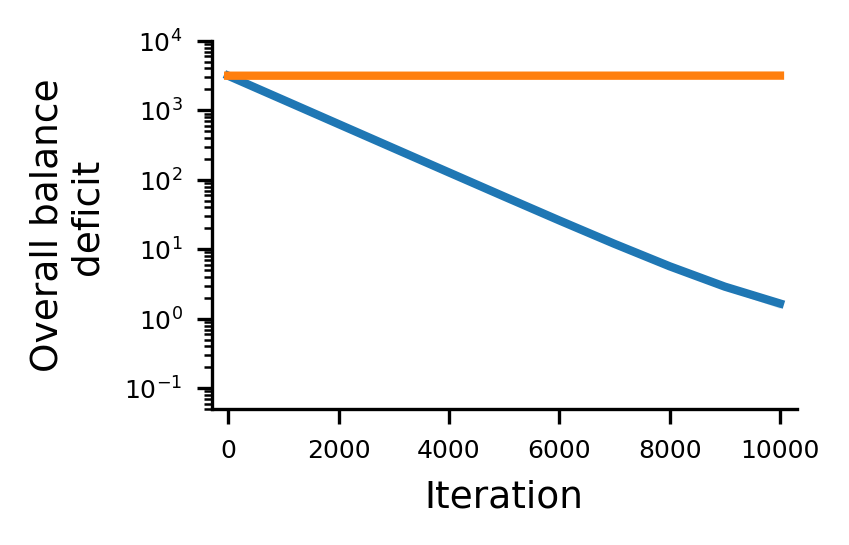

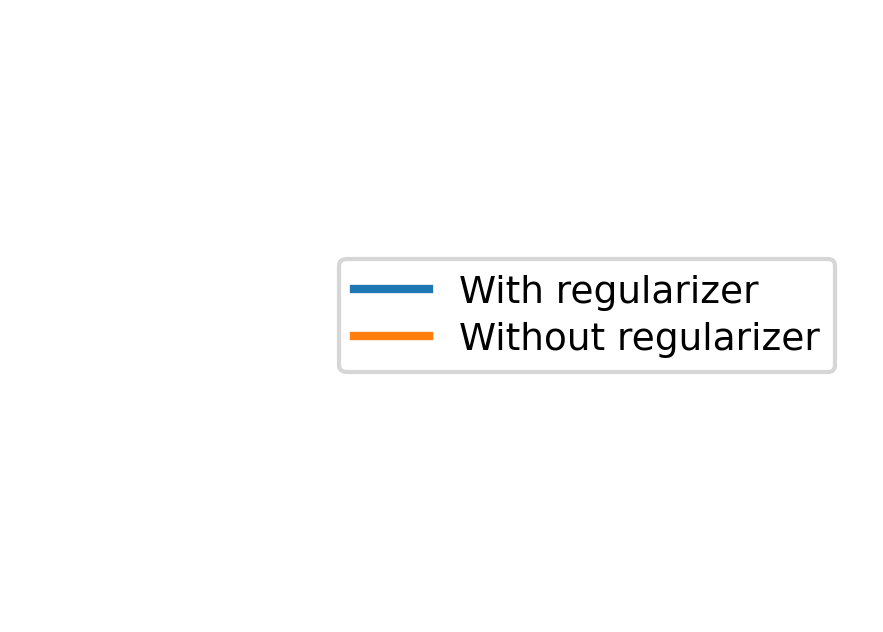

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr = CPU_Unpickler(fp).load()



max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')







#############################################################################################################################

x = LC_BP_with_L2_regularization_big_lr["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )





#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )




plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')
















plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Overall balance\n deficit", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)

ax.set_yscale('log')


# ax.ticklabel_format(style='sci',scilimits=(0,0), axis='y' )
ax.yaxis.get_offset_text().set_fontsize(plt_fontsize_label_)

plt.ylim(0.05,10000)

# ax.get_yaxis().get_offset_text().set_position((-0.05,0))

plt.xlim(-300,10300)




if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_wise_imbalancement_with_vs_without_regularizer.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With regularizer'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer'
, linewidth=1.3  , markersize = markersize_ , color = color_cycle[1])








ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_neuron_wise_imbalancement_with_vs_without_regularizer.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## plot LOSS with regularazer vs without regularizer

torch.Size([10, 10000])
100
torch.Size([10, 10000])


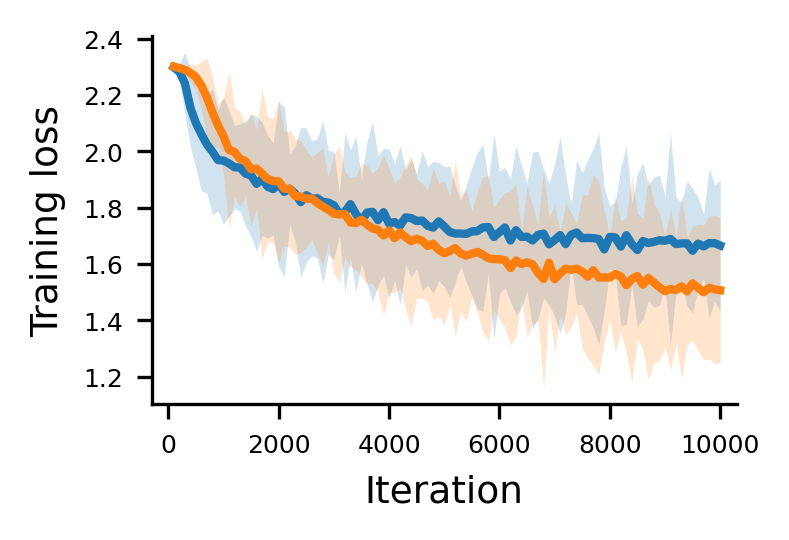

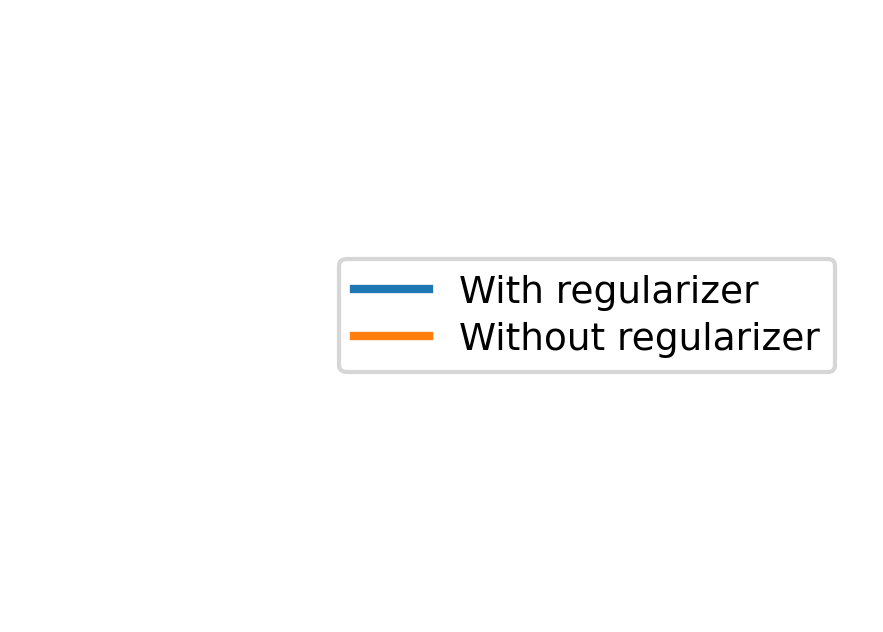

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr = CPU_Unpickler(fp).load()



max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')







#############################################################################################################################

x = LC_BP_with_L2_regularization_big_lr["loss_tensor"][:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )



print(len(x_list))


#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr["loss_tensor"][:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )

















plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Training loss", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


plt.xlim(-300,10300)


if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_loss_with_vs_without_regularizer.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With regularizer'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer'
, linewidth=1.3  , markersize = markersize_ , color = color_cycle[1])








ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_loss_with_vs_without_regularizer.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## plot norm of weights with regularazer vs without regularizer

torch.Size([10, 9999])
torch.Size([10, 9999])


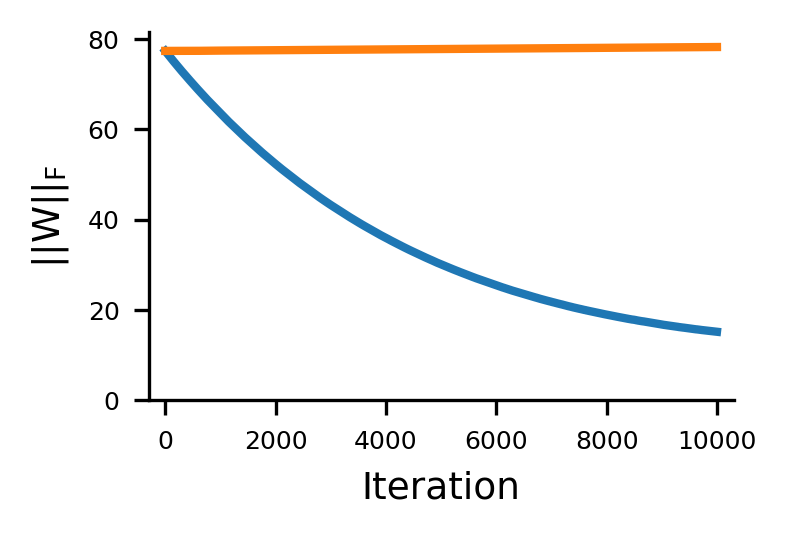

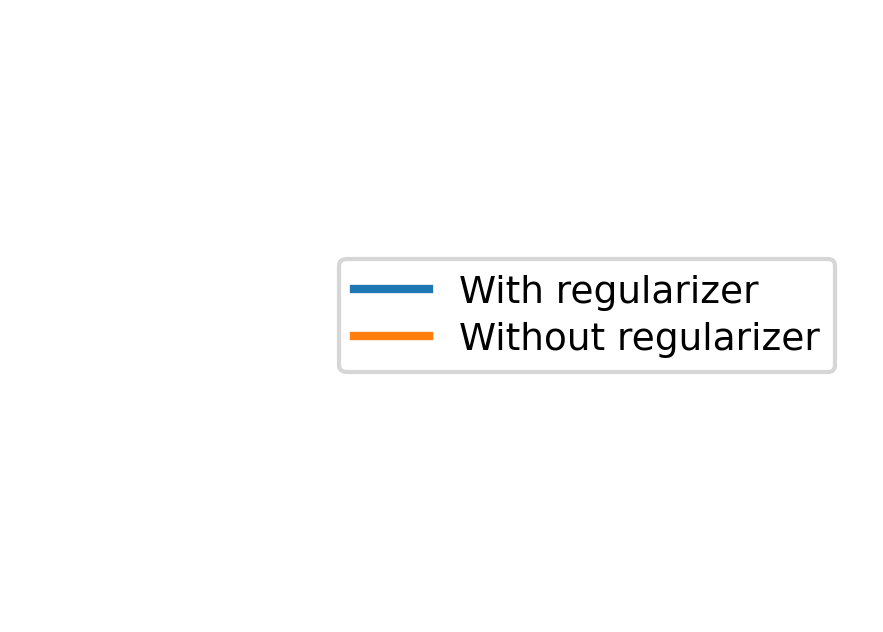

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = LC_BP_with_L2_regularization_big_lr["norm_W"][0,:,0:max_iteration].sqrt()

print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) *6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )



x = LC_BP_without_L2_regularization_big_lr["norm_W"][0,:,0:max_iteration].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) *6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )



plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W||_F$", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


axes = plt.gca()

plt.ylim(0,axes.get_ylim()[1])

plt.xlim(-300,10300)


if mount_drive:
    plt.savefig( base_directory_figure_str + '/norms_of_weights_with_vs_without_regularizer.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With regularizer'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer'
, linewidth=1.3  , markersize = markersize_ , color = color_cycle[1])








ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)

# plt.ylim(65,218)
# plt.yticks(list(range(70,181,10)))
leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_norms_of_weights_with_vs_without_regularizer.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## plot Neuron-wise imbalancement with initial balance

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([2, 9999])


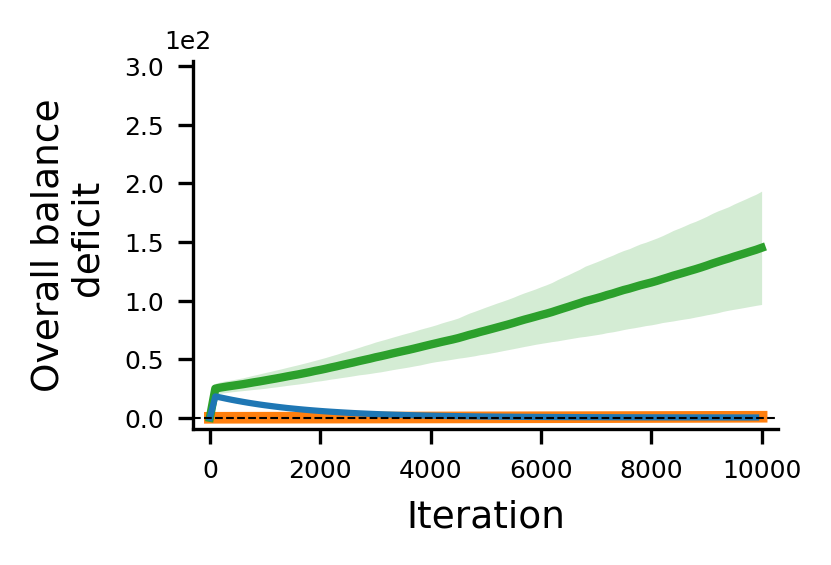

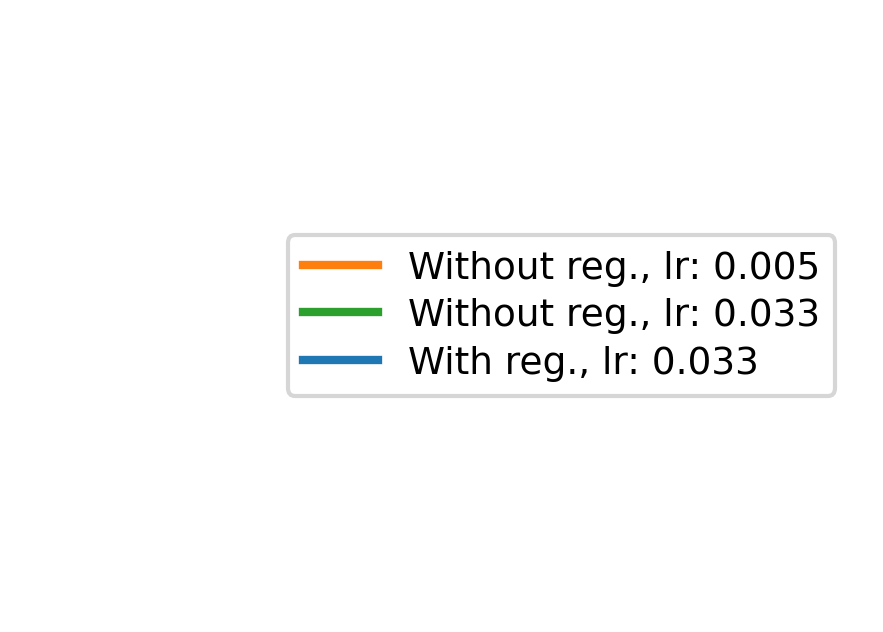

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_small_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()




max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')







#############################################################################################################################

x = LC_BP_without_L2_regularization_small_lr_initial_balance["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth= 2.8 , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )





#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr_initial_balance["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[2] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[2] )



#############################################################################################################################


x = LC_BP_with_L2_regularization_big_lr_initial_balance["neuron_wise_imbalancement"][0,:,0:max_iteration]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=1.5  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )





plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')

















plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Overall balance\n deficit", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)

axes = plt.gca()
plt.ylim(axes.get_ylim()[0],axes.get_ylim()[1]*1.5)


ax.ticklabel_format(style='sci',scilimits=(0,0), axis='y' )
ax.yaxis.get_offset_text().set_fontsize(plt_fontsize_label_)

plt.xlim(-300,10300)

ax.get_yaxis().get_offset_text().set_position((-0.05,0))


if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_wise_imbalancement_with_initial_balance.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without reg., lr: 0.005'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[1])

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without reg., lr: 0.033'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[2])




plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With reg., lr: 0.033'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])





ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_neuron_wise_imbalancement_with_initial_balance.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## plot LOSS with regularazer with initial balance

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([2, 9999])


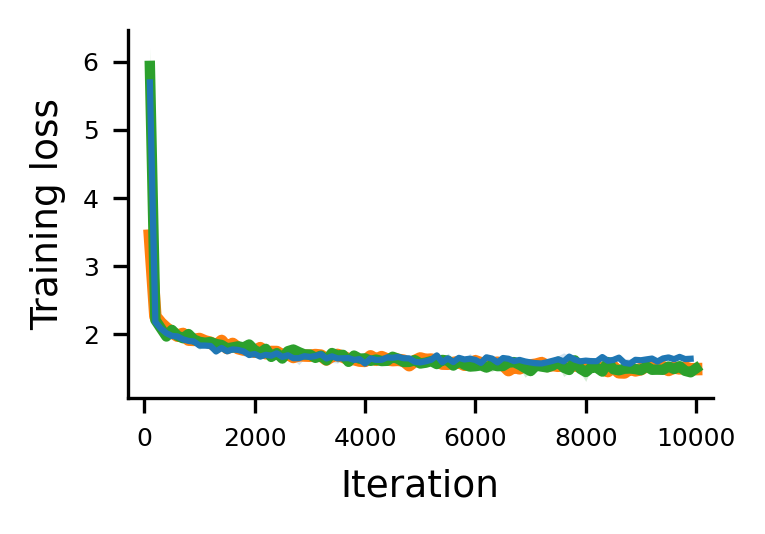

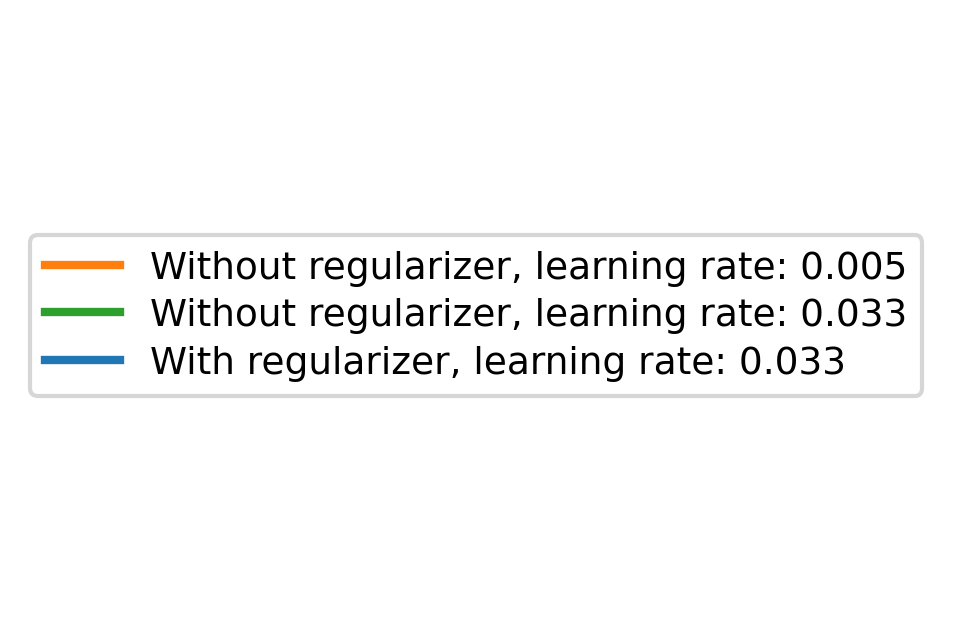

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_small_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')







#############################################################################################################################

x = LC_BP_without_L2_regularization_small_lr_initial_balance["loss_tensor"][:,0:]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth=3  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )





#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr_initial_balance["loss_tensor"][:,0:]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2.5  , markersize = markersize_ , color = color_cycle[2] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[2] )

#############################################################################################################################


x = LC_BP_with_L2_regularization_big_lr_initial_balance["loss_tensor"][:,0:max_iteration]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=1.5  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )


# plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')

















plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Training loss", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


plt.xlim(-300,10300)




if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_loss_with_initial_balance.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, learning rate: 0.005'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[1])

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, learning rate: 0.033'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[2])




plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With regularizer, learning rate: 0.033'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])





ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_loss_with_vs_initial_balance.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## plot norm of weights with with initial balance

torch.Size([2, 10000])
torch.Size([2, 10000])
torch.Size([2, 10000])


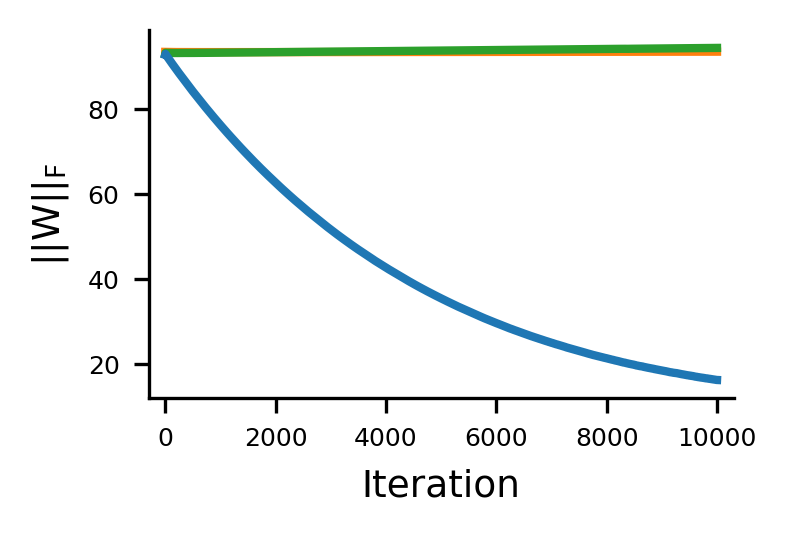

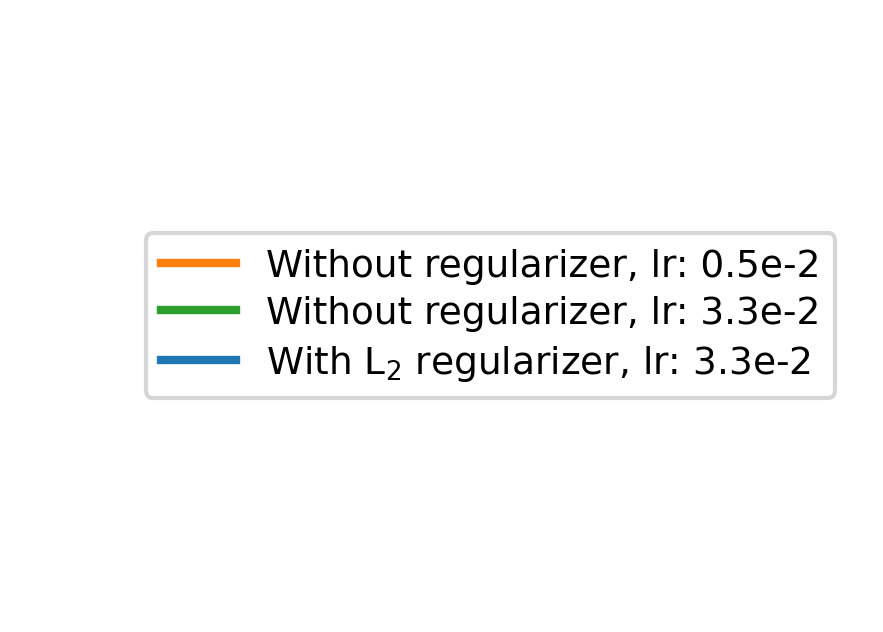

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_small_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = LC_BP_without_L2_regularization_small_lr_initial_balance["norm_W"][0,:,0:].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) *6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )



x = LC_BP_without_L2_regularization_big_lr_initial_balance["norm_W"][0,:,0:].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[2] )
x_std = x.std(dim=0) *6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[2] )

x = LC_BP_with_L2_regularization_big_lr_initial_balance["norm_W"][0,:,0:].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) *6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )

plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W||_F$", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


axes = plt.gca()
plt.ylim(axes.get_ylim()[0],axes.get_ylim()[1])


plt.xlim(-300,10300)


if mount_drive:
    plt.savefig( base_directory_figure_str + '/norms_of_weights_with_initial_balance.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()








###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')





plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, lr: 0.5e-2'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[1])

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, lr: 3.3e-2'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[2])




plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With $L_2$ regularizer, lr: 3.3e-2'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])






ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)

leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_norms_of_weights_with_initial_balance.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







# 3) various balancing algorithms converge to a balanced state, and always the same one.

In [ ]:
net1 = Net()
net1.to(device)
net1.set_shapes([1,3,32,32])



In [ ]:
net1.reinitialize_weights(.04)

net1.save_weights()

In [ ]:
net1.load_weights()

N_repeat = 1
N_iter  = 200
norm_W = torch.zeros( [ 1 , N_repeat , N_iter ]  )
neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_iter +1 ] );


for i in range(N_iter):
  # print(i)

  norm_W [0,0,i] = net1. norm_of_weights()
  neuron_wise_imbalancement[0,0,i] = net1.neuron_wise_imbalancement()
  if i%20 ==  0:
    print(neuron_wise_imbalancement[0,0,i] , norm_W [0,0,i])

  net1.stochastic_balance()

i+=1
neuron_wise_imbalancement[0,0,i] = net1.neuron_wise_imbalancement()

print(neuron_wise_imbalancement[0,0,i])

stochastic_balancing_first_time = {
    "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32)

}


W_balanced_conv1 = net1.conv1.weight.data.clone()
W_balanced_conv2 = net1.conv2.weight.data.clone()
W_balanced_conv3 = net1.conv3.weight.data.clone()
W_balanced_fc1 = net1.fc1.weight.data.clone()
W_balanced_fc2 = net1.fc2.weight.data.clone()
W_balanced_fc3 = net1.fc3.weight.data.clone()



tensor(3139.0161) tensor(5982.6714)
tensor(1869.1322) tensor(4645.6963)
tensor(448.1447) tensor(2436.9636)
tensor(102.7543) tensor(1520.6403)
tensor(17.1278) tensor(1437.3142)
tensor(5.6227) tensor(1415.3864)
tensor(1.5612) tensor(1402.8204)
tensor(3.0571) tensor(1398.3782)
tensor(0.3757) tensor(1396.8523)
tensor(0.1806) tensor(1396.4629)
tensor(0.0719)


In [ ]:

N_repeat = 10
N_iter  = 200
norm_W = torch.zeros( [ 1 , N_repeat , N_iter ]  )
neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_iter +1 ] );

distnce_to_first_balanced = torch.zeros( [ 1 , N_repeat , N_iter +1 ] );

for rep_i in range(N_repeat):
  net1.load_weights()

  for i in range(N_iter):
    # print(i)
    sum=0
    sum+= (W_balanced_conv1 - net1.conv1.weight.data).norm()**2
    sum+= (W_balanced_conv2 - net1.conv2.weight.data).norm()**2
    sum+= (W_balanced_conv3 - net1.conv3.weight.data).norm()**2
    sum+= (W_balanced_fc1 - net1.fc1.weight.data).norm()**2
    sum+= (W_balanced_fc2 - net1.fc2.weight.data).norm()**2
    sum+= (W_balanced_fc3 - net1.fc3.weight.data).norm()**2



    distnce_to_first_balanced[0,rep_i,i] = sum

    norm_W [0,rep_i,i] = net1. norm_of_weights()
    neuron_wise_imbalancement[0,rep_i,i] = net1.neuron_wise_imbalancement()
    if i%20 ==  0:
      print(neuron_wise_imbalancement[0,rep_i,i] , norm_W [0,rep_i,i] , distnce_to_first_balanced[0,rep_i,i])

    net1.stochastic_balance()


stochastic_balancing = {
     "norm_W" : norm_W.detach().clone().cpu().to(torch.float32),
    "distnce_to_first_balanced" : distnce_to_first_balanced,
  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32)

}

tensor(3139.0161) tensor(5982.6714) tensor(2667.2563)
tensor(379.7686) tensor(2779.8208) tensor(755.4697)
tensor(381.2894) tensor(2007.0778) tensor(293.1407)
tensor(84.5901) tensor(1612.0726) tensor(105.0795)
tensor(19.1325) tensor(1448.1210) tensor(24.6603)
tensor(3.5736) tensor(1415.6859) tensor(9.0184)
tensor(4.4396) tensor(1401.4766) tensor(2.1588)
tensor(0.1697) tensor(1397.2014) tensor(0.3215)
tensor(0.1751) tensor(1396.5385) tensor(0.0776)
tensor(0.0141) tensor(1396.3479) tensor(0.0144)
tensor(3139.0161) tensor(5982.6714) tensor(2667.2563)
tensor(499.8203) tensor(3006.5598) tensor(845.9783)
tensor(234.8207) tensor(2258.7021) tensor(474.3860)
tensor(52.5849) tensor(1537.9081) tensor(70.3669)
tensor(13.1948) tensor(1438.6444) tensor(20.3381)
tensor(3.1670) tensor(1415.9607) tensor(9.1545)
tensor(3.6856) tensor(1402.8728) tensor(2.8816)
tensor(7.2132) tensor(1398.9634) tensor(1.0276)
tensor(0.5898) tensor(1397.1925) tensor(0.3162)
tensor(0.1080) tensor(1396.5834) tensor(0.0821)
ten

In [ ]:

if mount_drive==True:

  str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( stochastic_balancing  , fp)

## Plot

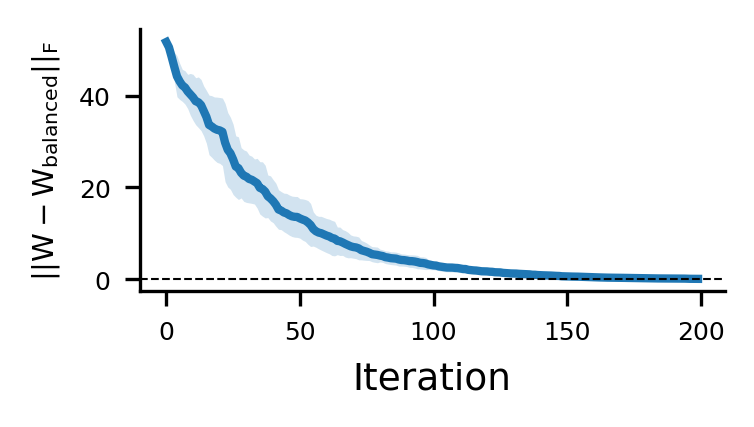

In [ ]:
str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  stochastic_balancing = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.32 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = stochastic_balancing["distnce_to_first_balanced"][0,:,0:max_iteration].sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )






plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W-W_{balanced}||_F$", fontsize= plt_fontsize_text_-2)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')




if mount_drive:
    plt.savefig( base_directory_figure_str + '/stochastic_balancing.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()









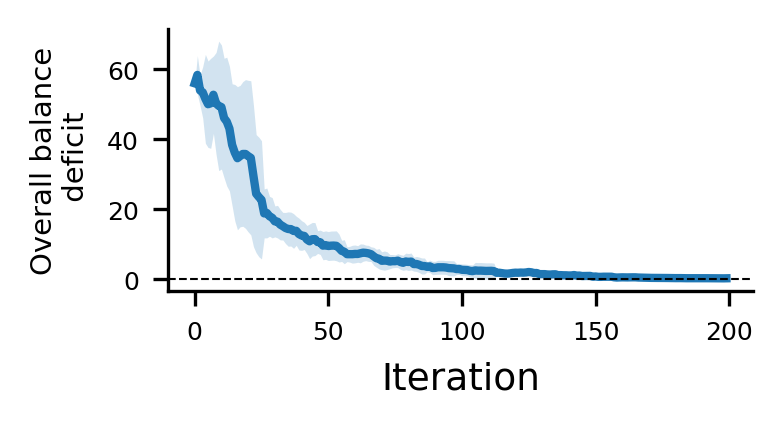

In [ ]:
if mount_drive==True:

    str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"


    with open( str_direction , "rb") as fp:   #Pickling
        stochastic_balancing = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.32 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = stochastic_balancing["neuron_wise_imbalancement"][0,:,0:-1].sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )






plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Overall balance\n deficit", fontsize= plt_fontsize_text_-2)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)



plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')



if mount_drive:
    plt.savefig( base_directory_figure_str + '/stochastic_balancing_neuron_wise_imbalancement.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()







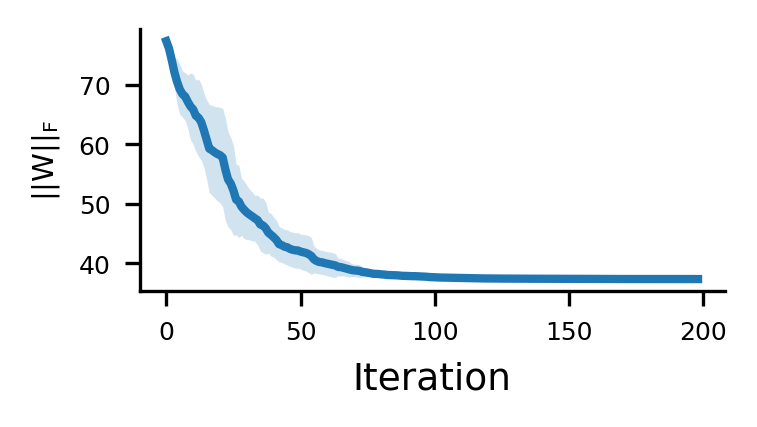

In [ ]:
str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  stochastic_balancing = CPU_Unpickler(fp).load()



max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.32 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = stochastic_balancing["norm_W"][0,:,0:max_iteration].sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )






plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W||_F$", fontsize= plt_fontsize_text_-2)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)




if mount_drive:
    plt.savefig( base_directory_figure_str + '/stochastic_balancing_L_2norm_.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()





